## Pre-Preliminary Version

### Sampling Methods for Imbalanced Samples

#### Project for the Statistical Modelling Course - Felix Adam

- Discuss what class imbalances are, see discussion in Kuhn & Johnson
- Often the case that the class of interest, is severely underrepresented in the data
- Also called the "minority" class
- Example: Dataset on rare disease, which is found in 10 out of 1000 people
- Let's say we apply logistic regression to this problem to classify patients in healty and unhealty
- Use the dataset of 1000 observations, have some features, fit logistic regression
- Then we test the accuracy, it turns out to be very high lets's say 99% correctly predicted
- Is this a good classifier? We have to check whether the 99% are actually meaningful
- Potential issue: Classifier assigns every patient to the healthy class, which still results in accuracy of 99%
- Naive approach would be to ditch the classifier and just tell everyone that they're healthy, potentially devestating results
- The issue: With such an imbalanced dataset, classifiers tend to perform badly, since they 'learn' the features of the majority class

Ironically, predicting rare events is one of the most important and interesting tasks in classification. Luckily, there are some techniques for dealing with class imbalances. 

I will first discuss the issues that arise when not accounting for class imbalances. Then I'll present undersampling of the majority class as simple remedy. I will later extend this method to synthetic oversampling using the Synthetic Minority Oversampling Technique (SMOTE). In the last section I'll discuss further applications, benefits and shortfalls of the presented techniques and other options available.

1. Show the problem
2. Undersampling
3. Oversampling
4. SMOTE (+ Undersampling)
5. Simulations of all methods on the same datasets
6. Discussion, when to use what, information content of data, etc, when do these techniques NOT help?

In [1]:
# Hide code for readability

In [237]:
%matplotlib inline

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import datasets
import itertools
from sklearn.utils import shuffle

# Function for making gaussian classification problem
def make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_min, mean_majority, sd_majority, cov_maj, random_state = "None"):
    
    """Helper function for creating classification problem with gaussians"""
    
    # Set random state
    if random_state != 'None':
        np.random.seed(random_state)
    
    # Split into majority and minority sizes
    n_minority = int(base_rate * n)
    n_majority = int((1-base_rate)* n)
        
    # Get mean of majority from seperation parameter
    #mean_majority = seperation * mean_minority
    
    # Assign covariance matrices
    cov_minority = np.array([[sd_minority[0],cov_min], [cov_min,sd_minority[1]]])
    cov_majority = np.array([[sd_majority[0],cov_maj], [cov_maj,sd_majority[1]]])
    
    # Make 2d multivariate for minortiy and majority class, assign classes
    x_minority = np.random.multivariate_normal(mean_minority,cov_minority, check_valid ='warn', size = n_minority)
    y_minority = np.ones(n_minority)
    
    x_majority = np.random.multivariate_normal(mean_majority,cov_majority, check_valid ='warn', size = n_majority)
    y_majority = np.zeros(n_majority)
    
    # Concatenate both to arrays
    x = np.concatenate((x_minority,x_majority),axis = 0)
    y = np.concatenate((y_minority,y_majority), axis = 0)
    
    # Shuffle
    x,y = shuffle(x,y)
        
    # Return arrays
    return x, y

# Helper function for plotting 
def plot_2d(X,y, title = '', figsize = (8,6)):
    
    fig, ax = plt.subplots(1,1, figsize = figsize)
    ax.scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    
    # Prettify
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set(xlabel="$X_1$", ylabel="$X_2$")

# Helper function for plotting the confusion matrix
def plot_confusion(cnf_matrix, classes = [0,1], title = 'Confusion Matrix', cmap = plt.cm.Blues,
                  figsize =  (8,6)):
    
    " Helper function for plotting a confusion matrix"
    fig, ax = plt.subplots(1,1, figsize = figsize)
    
    # Make heatmap plot
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Title, colorbar and tickmarks
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Write number of predictions in matrix
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if cnf_matrix[i, j] > thresh else "black")
    
    # Add labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Helper function for plotting the decision boundary in R^2
def plot_decision_boundary(model, X_test, y_test, area = [-5,5], figsize = (8,6), ):
    
    """Helper function for plotting the decsision boundary in R^2 """
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict probabilities on the grid
    probs = model.predict_proba(grid)[:,1 ].reshape(xx.shape)
    
    # Make figure and plot
    fig, ax = plt.subplots(figsize=figsize)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    
    # Set colorbar and labels for colorbar
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    # Scatter data points, color by class
    ax.scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)
    
    # Set ax labels
    ax.set(aspect="equal",
           xlim=(area[0],area[1]), ylim=(area[0], area[1]),
           xlabel="$X_1$", ylabel="$X_2$")
    
    
# Helper function for correcting the intercept in models fitted on re-sampled data
def correct_intercept_logit(fitted_model, population_y, sample_y):
    
    """ Helper funcion for correcting the intercept of a logit model after re-sampling.
        Both population inputs should be 0-1 class labels, where 1 is the class of interest""" 
    
    # Get the current intercept
    current_intercept = fitted_model.intercept_
    
    # Get population values, estimate them as averages from the population sample
    tau = sum(population_y) / len(population_y)
    
    # Resampled population values
    y_bar = sum(sample_y) / len(sample_y)
    
    # Calculate corrected coefficient 
    corrected_intercept = current_intercept - np.log( ((1-tau) / tau) * (y_bar / (1-y_bar)))
    
    # Set model intercept to corrected intercept
    fitted_model.intercept_ = corrected_intercept


def plot_roc_curve(model,X_test,y_test, figsize = (8,6)):
    
    """Helper function for plotting the ROC curve and AUC of given classifier"""
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    # Get false positive and true positive rates
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    # Get AUC
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    # Make figure
    fig, ax = plt.subplots(figsize = figsize)
    
    # Diagonal
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    
    # Plot ROC curve
    plt.plot(fpr,tpr,label="ROC Curve; AUC ="+str(round(auc,2)))
    
    # Legend and labels
    plt.legend(loc = 4)
    
    # Set ax labels
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
    
# Helper function for comparing original sample and re-sampled data set
def plot_resample(X,y, X_resample, y_resample, title = '', figsize = (16,8)):
    
    fig, axes = plt.subplots(1,2, figsize = figsize)
    fig.suptitle(title, fontsize=16)
    axes[0].scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    axes[1].scatter(X_resample[:,0], X_resample[:,1], c= y_resample, alpha = 0.8, edgecolor='k')

    axes[0].set_title('Original Set')
    axes[1].set_title('Re-Sampled')

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))
        ax.set(xlabel="$X_1$", ylabel="$X_2$")
        
#Helper function for comparing decsision boundaries of two classifiers in R^2
def plot_decision_resample(models, X_test,y_test, titles , suptitle = 'Decision Boundaries', area = [-5,5], figsize =(16,8)):
    
    """Helper function for comparing decsision boundaries in R^2 """
    fig, axes = plt.subplots(1,len(models), figsize = figsize)
    
    fig.suptitle(suptitle)
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    for i in range(0,len(models)):
        
        # Predict probabilities on the grid
        probs = models[i].predict_proba(grid)[:,1].reshape(xx.shape)
        
        # add contour
        contour = axes[i].contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
        
         # Scatter data points, color by class
        axes[i].scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
                       cmap="RdBu", vmin=-.2, vmax=1.2,
                       edgecolor="white", linewidth=1)
        
        # Set title 
        axes[i].set_title(titles[i])
        # Set ax labels
        axes[i].set(aspect="equal",
               xlim=(area[0],area[1]), ylim=(area[0], area[1]),
               xlabel="$X_1$", ylabel="$X_2$")
        
#Helper function for comparing decsision boundaries of two classifiers in R^2
def plot_decision_resample(models, X_test,y_test, titles , suptitle = 'Decision Boundaries', area = [-5,5], figsize =(16,8)):
    
    """Helper function for comparing decsision boundaries in R^2 """
    fig, axes = plt.subplots(1,len(models), figsize = figsize)
    
    fig.suptitle(suptitle)
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    for i in range(0,len(models)):
        
        # Predict probabilities on the grid
        probs = models[i].predict_proba(grid)[:,1].reshape(xx.shape)
        
        # add contour
        contour = axes[i].contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
        
         # Scatter data points, color by class
        axes[i].scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
                       cmap="RdBu", vmin=-.2, vmax=1.2,
                       edgecolor="white", linewidth=1)
        
        # Set title 
        axes[i].set_title(titles[i])
        # Set ax labels
        axes[i].set(aspect="equal",
               xlim=(area[0],area[1]), ylim=(area[0], area[1]),
               xlabel="$X_1$", ylabel="$X_2$")
    
    # Add shared colorbar
    cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    ax_c =  fig.colorbar(contour, cax=cax, **kw)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

#### 1. The issue

- Relative frequency of the classes can have a significant impact on effectivness (Kuhn & Johnson)
- Often results in good specificity and bad sensitivity (Kuhn & Johnson)
- Examples can be found in many applications

Following i'll show an example in 2D space
- This example is chosen to demonstrate when class imbalances are of a particular issue (small seperation, etc)
- Followed by example of when class imbalance is less of an issue

##### Example in $R^2$

- My base rate is 1%, with a sample size of 5000, so only 50 instances of the minority class
- Gaussian features, let's assume that minority class is less disperesed than the majority
- Both clusters are relatively close to each other in terms of means of both features
- Covariance between features 0

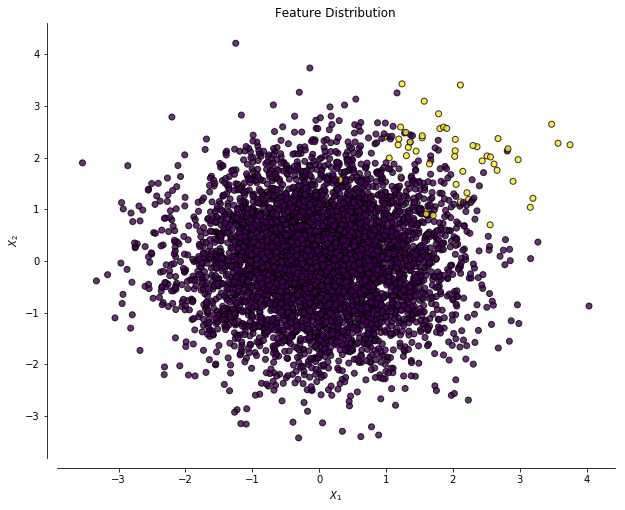

In [627]:
## Making the data ##
# Random state for reproduceability
seed = 4

# Base rate and sample size
base_rate = 0.01
n = 5000

# Properties of the minority class distribution
mean_minority =  np.array([2,2])
sd_minority = np.array([0.5,0.5])
cov_minority = 0

# Majority class parameters
mean_majority = np.array([0,0])
sd_majority = np.array([1,1])
cov_majority = 0

# Make distribution and classes
x, y = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, mean_majority,
                        sd_majority,cov_majority, random_state = seed)
# Plot
plot_2d(x,y, figsize= (10,8), title= 'Feature Distribution')

- One can see, that this is a hard problem in general, due to low seperation of both clusters.
- Will come back to the discussion of when class imbalance is actually a problem!
- Now follow the usual procedure of splitting the data into training and a testing set
- Split is done stratified, so that both sets have the same class distribution (base rate)
- Train the model on the training set
- Test model on the testing set

In [628]:
## Train test, split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y, random_state= 0)

In [629]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
baseline_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
baseline_model.fit(X_train,y_train);

# Now make probability predictions
baseline_proba = baseline_model.predict_proba(X_test)[::,1]

# Set decision boundary, will be used for all subsequent analysis (?)
boundary = 0.5

# Turn probabilistic predictions into class predictions
baseline_pred = [1 if p >= boundary  else 0 for p in baseline_proba]
 
# Get scores and display 
accuracy_baseline = metrics.accuracy_score(y_test, baseline_pred)

print('Overall accuracy score: ' + str(accuracy_baseline) + "\n")
print(metrics.classification_report(y_test, baseline_pred))

Overall accuracy score: 0.9944

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2475
         1.0       0.79      0.60      0.68        25

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.89      0.80      0.84      2500
weighted avg       0.99      0.99      0.99      2500



- We can see very high accuracy
- However, base rate was 1% so not very meaningful!
- Relatively high precision for both classes
$\text{ Precision } = P [ y = 1 \mid \hat { y } = 1 ]$ <=>
$\text{Precision} = \frac{TP}{TP + FP}$
- If an instance is predicted to be of class 1, then it's quite likely to be true
- Recall is low for the class of interest
$\text{Recall} = P[\hat{y} = 1 \mid y = 1 ]$ <=>
$\text{Recall} = \frac{TP}{TP + FN}$
- Recall shows percentage of correctly classified positive cases, ability to find "interesting" cases
- f1 score is the harmonic mean of precision and recall
- Overall, perfrmance for the 0 class is very good, performance for the 1 class is poor

Check the confusion matrix to show the issue

In [630]:
print(metrics.precision_score(y_test,baseline_pred))
print(metrics.recall_score(y_test,baseline_pred))

0.7894736842105263
0.6


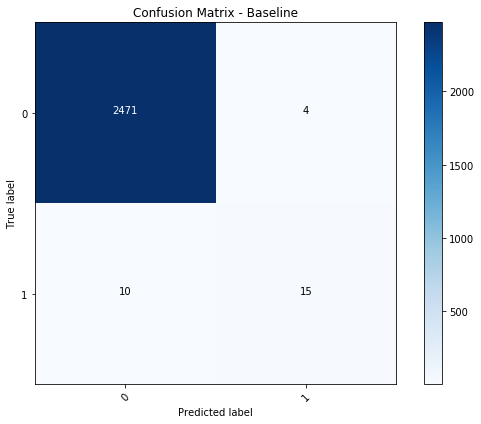

In [632]:
# Get confusion matrix using sklearn metrics
cnf_matrix = metrics.confusion_matrix(y_test,baseline_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Baseline', classes= ['0','1'],figsize=(8,6))

- Classifier is very good at finding members of the 0 class
- However, performance for class of interest is very low
- Depending on the issue, this could be devestating
- Maybe class 1 signifies rare diseases, miss-classifying these would be horrible
- What to focus on ultimately reverts back to the underlying problem
- Usually, identifiying the rare cases is the important task, otherwise it probably wouldn't be an important ML issue!
- Discuss shortly descision boundary!
- How does the decsision boundary for the classifier look like?

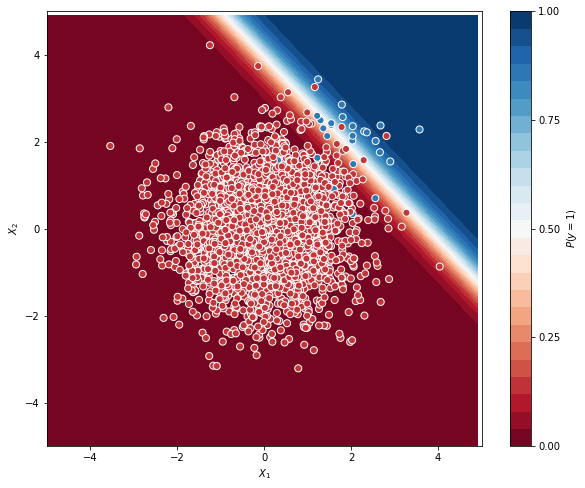

In [633]:
plot_decision_boundary(baseline_model, X_test, y_test,figsize=(10,8))

- Decsision boundary is largely influenced by the majority class
- Outliers of majority class "conceal" mean of minority class
- First one can and should always test solution: move the decsision boundary
- In this case a move to a decsision boundary of 0.25 would already capture all minority class instances
- We can check this in using the ROC curve

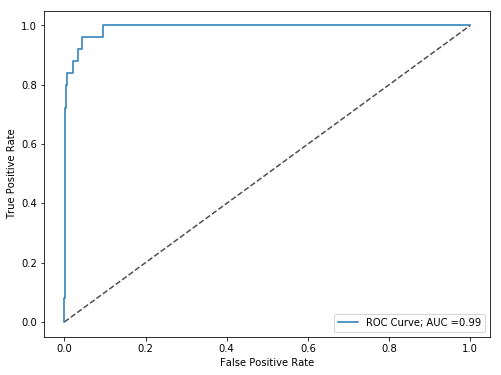

In [634]:
plot_roc_curve(baseline_model, X_test, y_test)

- ROC Curve actually not too bad
- Almost perfect AUC!
- Shows, that the issue is less one of class imbalance in general in R^2, problem more pronounced in higher dimensional spaces, also then a problem of variable selection
- Will demonstrate that with another example

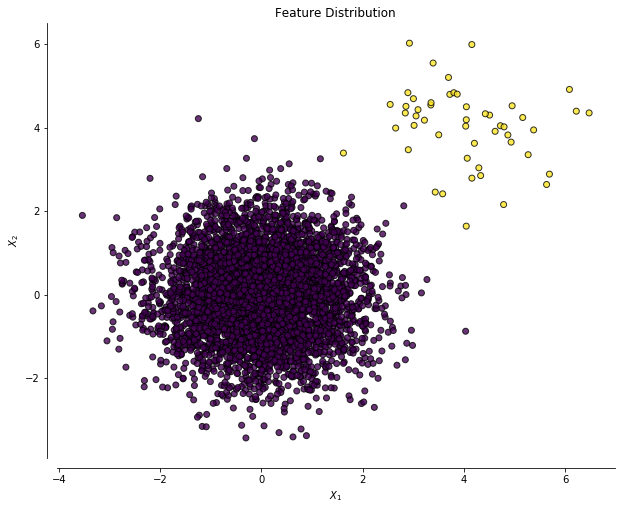

In [635]:
# Base rate and sample size
base_rate = 0.01
n = 5000

# Properties of the minority class distribution
mean_minority =  np.array([4,4])
sd_minority = np.array([1,1])
cov_minority = 0

# Majority class parameters
mean_majority = np.array([0,0])
sd_majority = np.array([1,1])
cov_majority = 0

# Make distribution and classes
x_2, y_2 = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, mean_majority,
                        sd_majority,cov_majority, random_state = seed)


# Plot
plot_2d(x_2,y_2, figsize= (10,8), title= 'Feature Distribution')

- Still highly imbalanced, now the difference is that the seperation between both is large
- Classifier should be able to deal with this a lot better
- Still highly imbalanced sample, base rate at 1%
- However, due to high seperation between two samples,classifier works really well and decsision boundary is "sharp"
- Will now return to the previous case and demonstrate the use of different sampling techniques
- Then I'll run simulations in higher dimensional space


#### Sampling Techniques
- General Idea behind sampling techniques
- When researcher knows that there is a severe class imbalance problem, potential solution is to balance the sample, so that the classifier can be trained on a balanced sample (Kuhn & Johnson)
- The goal is that the classifier can capture the decision boundary better on a balanced sample
- Major techniques: Over- & undersampling, hybrid of boths 

Random Under Sampling
- Basic idea:Majority class instances are removed at random, until a more balanced distribution is reached (Hoens and Chawla in He & Ma)
- Many extensions that try to make a "smart" decision on what to remove.
- Using clustering, tomek links, etc.
- Different levels of under / over-sampling possible, e.g. 50/50, 80/20, etc.
- Potential drawbacks: Discarding of informative data (potential remedy in smart methods)

Random over sampling
- Copy and repeat the minority class instances until desired level of balance is achieved (Hoens and Chawla in He & Ma)
- Here also "smart" extensions, one of them generating synthetic examples sing SMOTE (cite) or ADASYN (cite), will be discussed later
- Potential drawbacks: Strong overfitting, classifier will have a hard time to generalize (Hoens and Chawla in He & Ma)

Hybrids of both methods are possible, will later discuss generation of synthetic samples.

- Now present under- and oversampling

#### Random Under-Sampling

- Will now present the random under sampling method
- Using pythons imbalanced learn package
- Will continue with the first example for visualization purposes
- later extend to higher dimensions 
- Apply the methods on the TRAINING set, then test the resulting classifier on testing set
- Caution: Correct intercept for logistic classifier
- Undersample to make a completly balanced sample -> Sampling strategy = 1
- For more "imbalance" set strategy towards 0

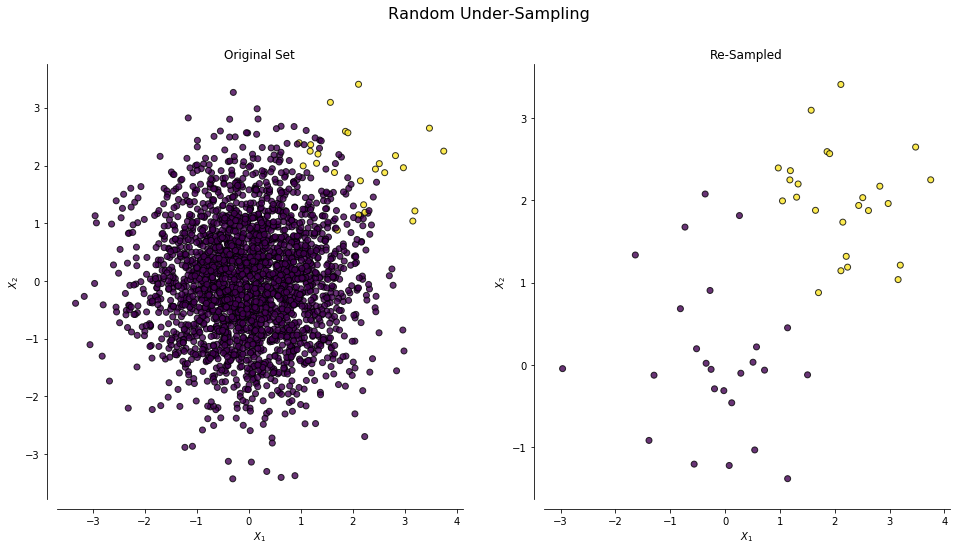

In [636]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the 
rus = RandomUnderSampler(sampling_strategy=1, random_state=2)

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)
plot_resample(X_train,y_train,X_train_undersampled,y_train_undersampled,title = 'Random Under-Sampling')

- Using random under-sampling to get a "balanced" sample
- Naive approach removes instances from the majority class completly random
- What does this do to perforamance?
- Fit a new classifier, makes comparison easier
- Note: The fact, that the split is "perfect" is due to randomness!

Correction for sampling method:
- Discuss here 

In [637]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
undersampled_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
undersampled_model.fit(X_train_undersampled,y_train_undersampled);

# Correction the intercept
correct_intercept_logit(undersampled_model, y_train, y_train_undersampled)

# Now make predictions
undersample_pred = undersampled_model.predict(X_test)

# Get scores and display 
accuracy_undersample = metrics.accuracy_score(y_test, undersample_pred)

print('Overall accuracy score with under-sampling: ' + str(accuracy_undersample) + "\n")
print(metrics.classification_report(y_test, undersample_pred))

Overall accuracy score with under-sampling: 0.9688

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      2475
         1.0       0.24      0.96      0.38        25

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.62      0.96      0.68      2500
weighted avg       0.99      0.97      0.98      2500



- Precision went down compared to previous case (for the 1 class)
- Recall is now a lot better, this is kind of what we wanted!
- Shows a trade-off between the two!

In [638]:
print(metrics.precision_score(y_test,undersample_pred))
print(metrics.recall_score(y_test,undersample_pred))

0.2376237623762376
0.96


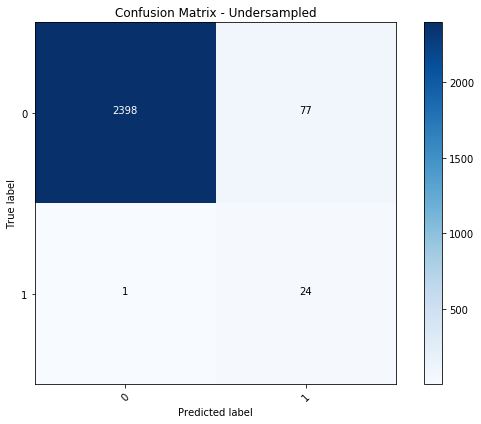

In [639]:
# Get confusion matrix using sklearn metrics
cnf_matrix_undersample = metrics.confusion_matrix(y_test,undersample_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix_undersample, title= 'Confusion Matrix - Undersampled', classes= ['0','1'],figsize=(8,6))

- Prediction for the 1 class has significantly improved!
- More false positive predictions, but relative to true negative predictions very low
- Would also need to take into account, that these are rare cases of the majority class

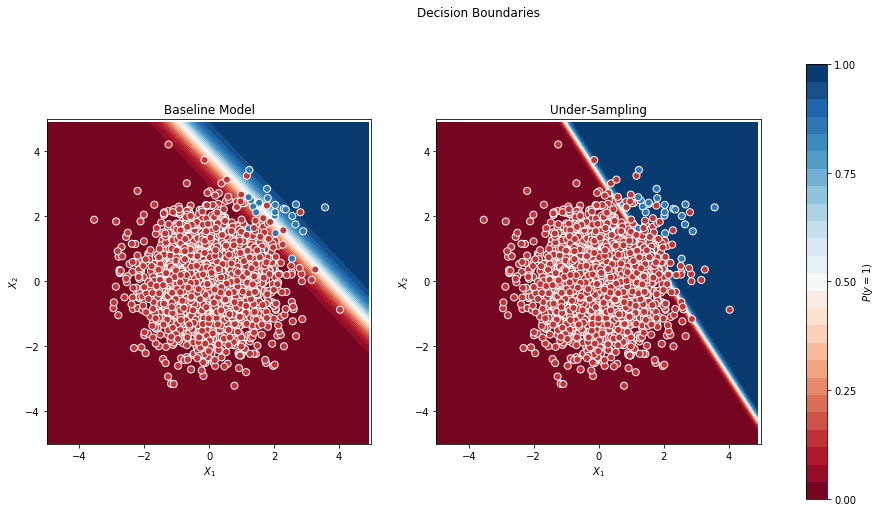

In [640]:
# Compare resulting decsision boundaries
plot_decision_resample([baseline_model,undersampled_model],X_test,y_test, titles= ['Baseline Model', 'Under-Sampling'])

- Striking difference in the decsision boundary
- Boundary is now "sharper",
- We can see the effect on precision and recall, more instances of the majority class are now being classified as 1

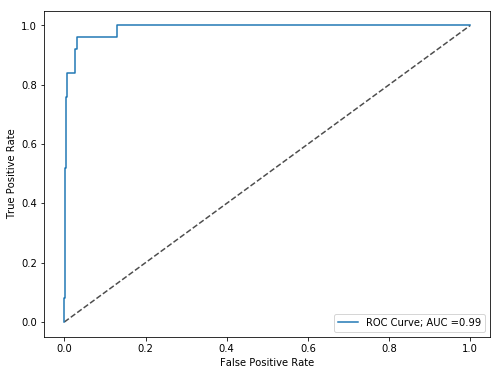

In [641]:
plot_roc_curve(undersampled_model, X_test, y_test)

- ROC curve now difference!

#### Random Over-Sampling
- Now use random over-sampling
- Follow same strategy as for under-sampling, but now repeat instances of the minority class instead of removing instances of majority class
- Also make a 50/50 balanced sample

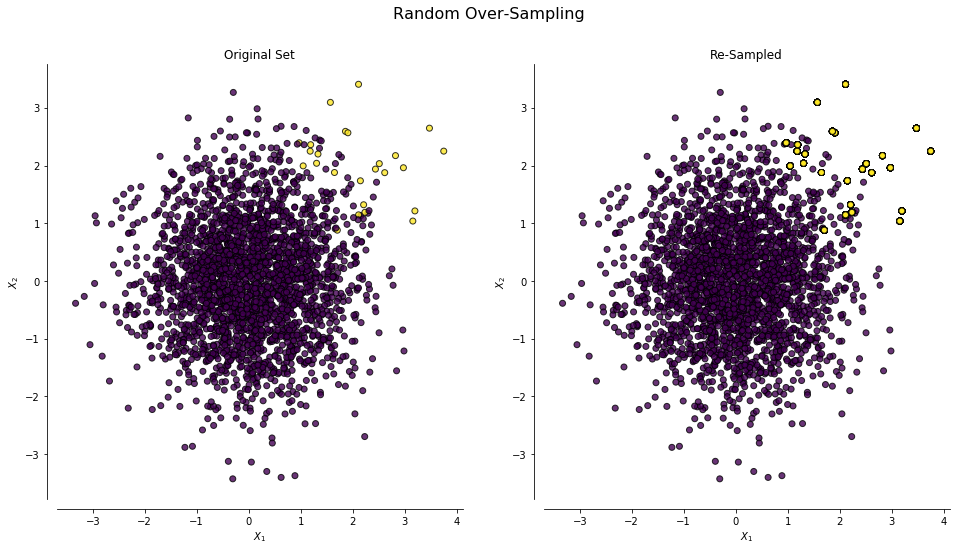

In [642]:
from imblearn.over_sampling import RandomOverSampler
random_oversampler = RandomOverSampler(sampling_strategy = 1,random_state=0)
X_train_oversampled, y_train_oversampled = random_oversampler.fit_resample(X_train, y_train)

plot_resample(X_train,y_train,X_train_oversampled,y_train_oversampled,title = 'Random Over-Sampling')

- Difference hard to see now, but one can slightly see the that the "thickness" of the circles of the minority class has increased
- this is due to the fact, that every minority class sample has now been repeated X times!
- sample is also balanced now!

In [643]:
# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
oversampled_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
oversampled_model.fit(X_train_oversampled, y_train_oversampled );

# Correct the intercept 
correct_intercept_logit(oversampled_model, y_train, y_train_oversampled)

# Make predictions on testing values
oversample_pred = oversampled_model.predict(X_test)

# Get scores and display 
accuracy_oversample = metrics.accuracy_score(y_test, oversample_pred)

print('Overall accuracy score with over-sampling: ' + str(accuracy_oversample) + "\n")
print(metrics.classification_report(y_test, oversample_pred))

Overall accuracy score with over-sampling: 0.9944

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2475
         1.0       0.74      0.68      0.71        25

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.87      0.84      0.85      2500
weighted avg       0.99      0.99      0.99      2500



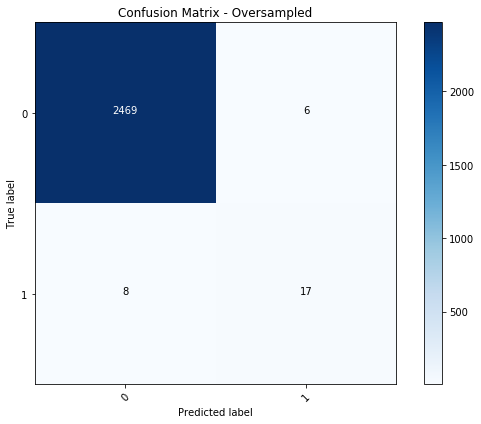

In [644]:
# Get confusion matrix using sklearn metrics
cnf_matrix_oversample = metrics.confusion_matrix(y_test,oversample_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix_oversample, title= 'Confusion Matrix - Oversampled', classes= ['0','1'],figsize=(8,6))

- Performance out of sample did not improve massively
- Maybe due to overfitting, check the decsision boundary

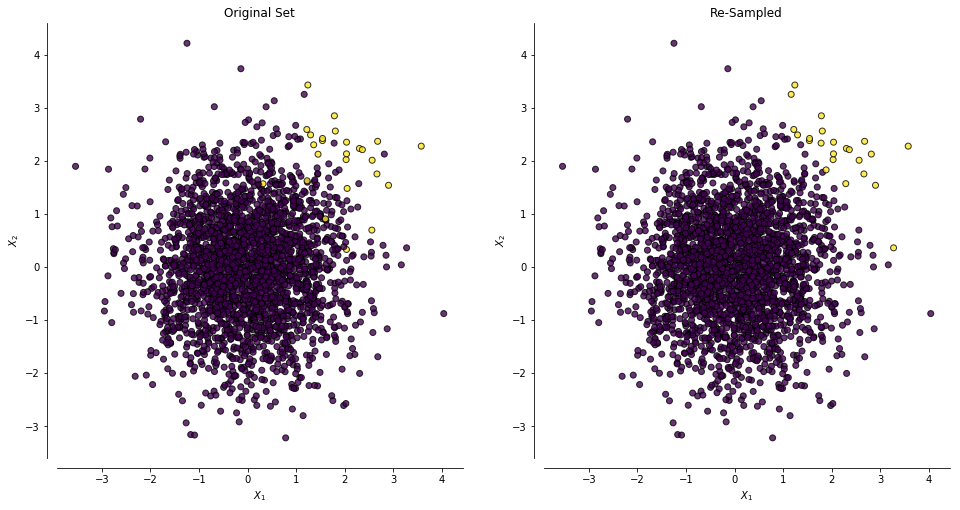

In [645]:
plot_resample(X_test,y_test,X_test, oversample_pred)

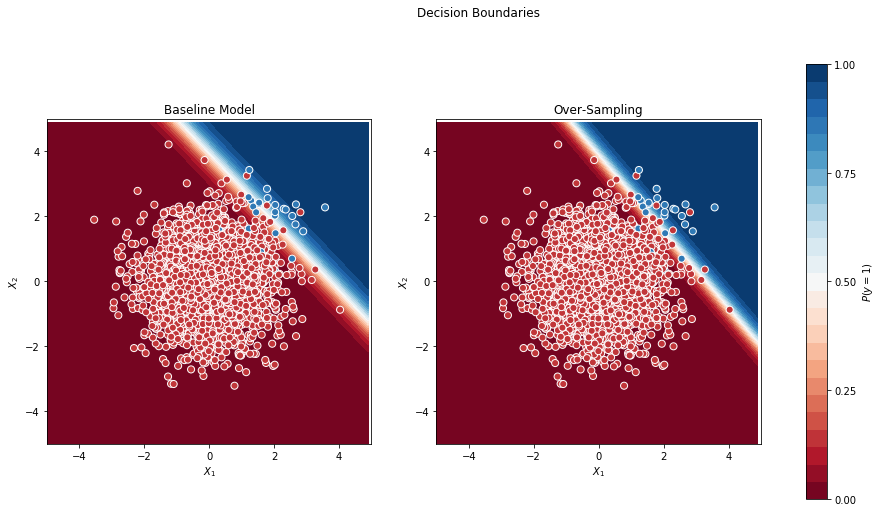

In [646]:
# Compare resulting decsision boundaries
plot_decision_resample([baseline_model,oversampled_model],X_test,y_test, titles= ['Baseline Model', 'Over-Sampling'])

- Eyeballing the boundaries, not much changed, which is kind of in line with prediction performance
- What about coefficients?


In [647]:
print("Baseline Coefficients: " + str(baseline_model.coef_))
print("Over-sampled Coefficients: " + str(oversampled_model.coef_))

Baseline Coefficients: [[3.43152418 3.25721862]]
Over-sampled Coefficients: [[5.03094833 4.27261268]]


- higher coefficients overall, note, intercepts are similar due to correction

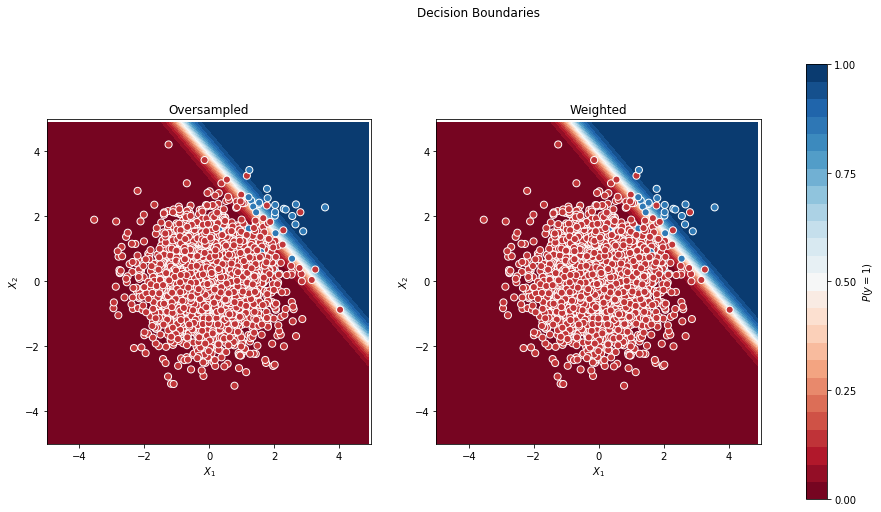

In [43]:
plot_decision_resample([oversampled_model ,weighted_model], X_test, y_test, titles = ['Oversampled', 'Weighted'])

#### SMOTE Chawla et al (2002)

##### Abstract
- Approach for dealing with imbalanced datasets
- Imbalance: Not equal representation of classification categories
- Happens often in the real world
- Cost of misclassifying an "interesting" example are a lot higer than misclassifying "normal" examples
- Paper shows a combination of over-sampling the minority class and under-sampling the majority class
- This can achive better performance in ROC space than only under-sampling the majority class
- Method involves creating synthetic minority class examples

##### Introduction

- Imbalance of order 100 to 1 can be found in fraud detection 
- others report imbalances of up to 100.000 to 1 (Provost & Fawcett, 2001)
- Performance is often evaluated using predictive accuracy 
- Not appropriate when data is imbalanced and/or costs of different errors vary 
- Example: Cancer prediction / mammography 
- In the case of severe imbalance, a simple strategy of always predicting the majority class would give an almost perfect predicitve accuracy
- Simple predictive accuracy is not appropriate in such situations!
- AUC is an accepted tradional performance metric 
-  ROC Convex Hull -> Very interesting, check it out!

How has the machine learning community addressed the issue of class imbalance?
- Assign distinct costs to training examples
- Re-sample the original dataset
        - Either over sample the minority class
        - And / Or under-sample the majority class
    
Approach presented in the paper uses under-sampling of the majority class with a special form of over-sampling of the minority class

##### Performance Measures
- Performance is typically evaluated by a confusion matrix
- In the context of balanced datasets and equal error costs, it is reasonable to use error the error rate as a performance metric
$$ error = 1- Accuracy$$

- In presence of imbalanced datasets with unequal error costs, more appropriate to use the ROC curve
- ROC curves can be thought of as representing the family of best decision boundaries for relative costs of TP and FP
- X axis: % False positives
- Y axis: % True positives
- Ideal point on the ROC curve would be (0,100), all positive examples are classified correctly and no negative examples are misclassified as positive
- One way a ROC curve can be swept out is by manipulating the balance of training samples for each class in a training set

##### Previous Work: Imbalanced datasets 
- Kubat and Matwin (1997) selectively under-sample the majority class while keeping the original population of the minority class
- Minority examples were divided into four categories: Some noise overlapping the positive class descision regon, borderline samples, redundant samples and safe samples
- Ling and Li (1998): Combine over-sampling the minority class with under-sampling the majority class
- used lift analysis instead of accuracy
- lift curve is more similar to an ROC curve, but more tailored to marketing
- Solberg and Solberg (1996): Oil-slick classification, balance 50-50, achieved 14% error rate on the interesting samples and 4 % error on the "negative" samples
- Precision and recall

*Literature summary: Under-sampling the majority class enables better classifiers to be built than over-sampling the minority class!*
-> Very interesting summary, check?
- Combination of the two as done in previous work does not lead to classifiers that outperform those built with undersampling of majority
- Oversampling of the minority class has been donw by sampling with replacement from the original data, this might be an issue -> SMOTE

#### SMOTE

- Previous research discussed over-sampling with replacment and showed that it doesn't significantly improve minority class recognition
- Authors argue with underlying effect in terms of descision region feature space
- As the minority class is over-sampled by increasing amounts, the effect is to identify similar but more specific regions in the feature space as the descision region for the minority class

Understanding over- and undersampling in terms of descision regions
-> Descision boundary for linear regression?

- Propose an over-sampling approach in which the minority class is over-sampled by creating synthetic examples, rather than oversampling with replacement
- Inspired by handwriting recognition: Used real pictures and perturbed the data a bit to generate new samples
- Generate synthetic examples by operating in "feature space" not "data space"
- Taking each minority class sample, introducing synthetic examples along the line segments, joining any / all of the k-miniority class nearest neighbors
- Samples are generated by taking the difference between the feature vector (sample) under consideration and it's nearest neighbor.
- Multiply this difference by a random number between 0 and 1, add it to the feature vector under consideration
- Causes the selection of a random point along the line segment between two specific features
- Forces the decision region of the minority class to become more general
- The amount of over-sampling is a parameter of the system, series of ROC curves can be generated for different populations and ROC analysis performed

- Synthetic samples cause the classifier to create larger and less specific decision regions, rather than smaller and more specific regions
- Better for decision trees?

##### Under-sampling and SMOTE Combination
- Majority class under-sampled, by randomly removing samples until the minority class becomes some specififed percentage of the majority class
- Forces the learner to experience varying degrees of under-sampling
- By applying a combination of under-sampling and over-sampling, the inital bias of the learner is reversed in favor of the minority class
- This is a crucial but somewhat overlooked part of the paper! 
- The best performance is reached when combining SMOTE and under-sampling of the majority class

> Combination of SMOTE and under-sampling is the way to go according to the authors

- Will no apply SMOTE using the imbalanced learn library

SMOTE using 5 nearest neighbtors, and trying to achieve a balanced sample with 50/50 distribution

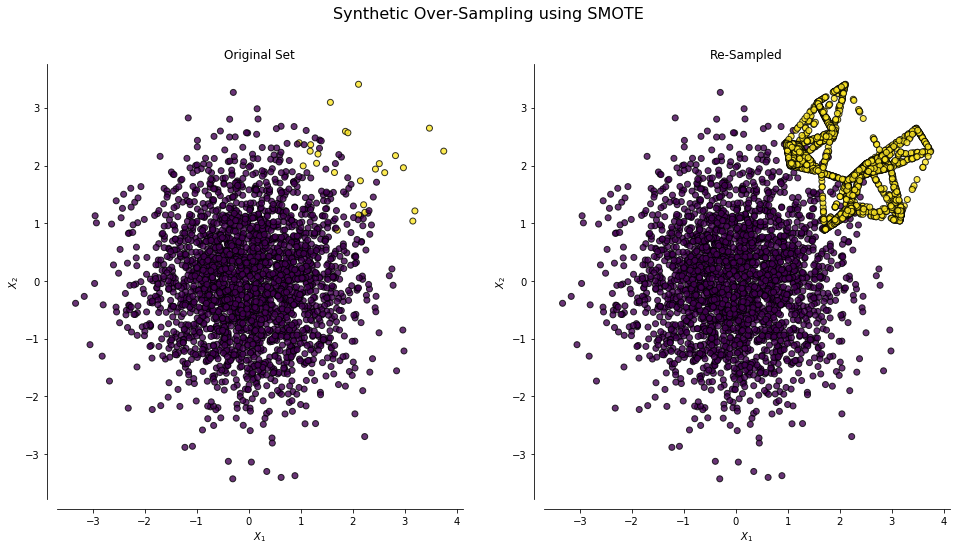

In [77]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(k_neighbors=5 ,sampling_strategy= 1, random_state= 0)

# Use smote to resample
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)
print()
plot_resample(X_train,y_train, X_train_smote,y_train_smote, title='Synthetic Over-Sampling using SMOTE')

- Can see, that instead of resampling the same instances over and over again, smote produces "new" instances
- Somewhat evenly spaced 
- Makes actually an "odd" looking distribution
- Now assess the performance of the model trained on the "smoted" dataset

In [211]:
# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
smote_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
smote_model.fit(X_train_smote, y_train_smote);

# Correct the intercept 
correct_intercept_logit(smote_model, y_train, y_train_smote)

# Make predictions on testing values
smote_pred = smote_model.predict(X_test)

# Get scores and display 
accuracy_smote = metrics.accuracy_score(y_test, smote_pred)

print('Overall accuracy score with Smote: ' + str(accuracy_smote) + "\n")
print(metrics.classification_report(y_test, smote_pred))

Overall accuracy score with Smote: 0.9936

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2475
         1.0       0.67      0.72      0.69        25

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.83      0.86      0.84      2500
weighted avg       0.99      0.99      0.99      2500



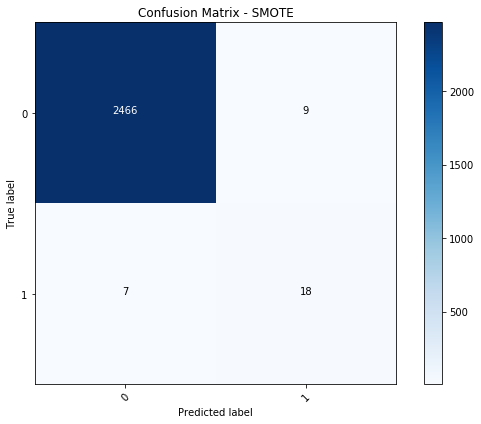

In [256]:
# Confusion matrix
cnf_matrix_smote = metrics.confusion_matrix(y_test,smote_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix_smote, title= 'Confusion Matrix - SMOTE', classes= ['0','1'],figsize=(8,6))

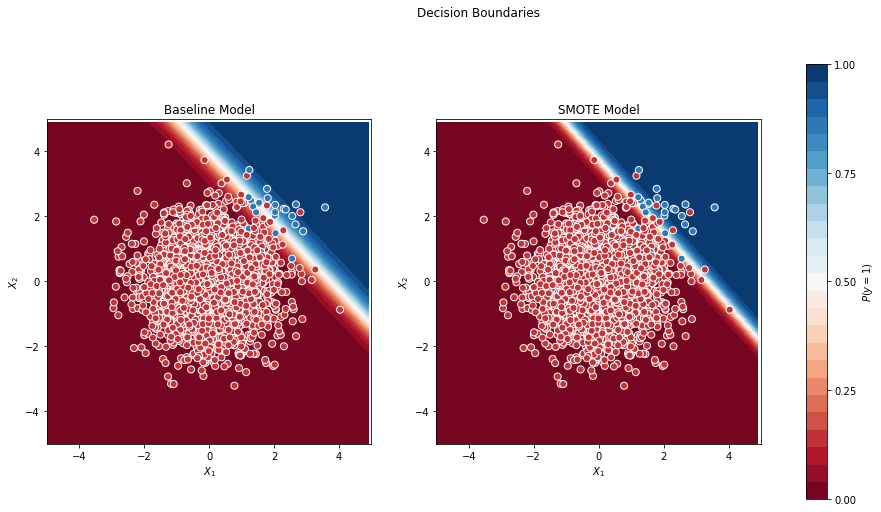

In [47]:
plot_decision_resample([baseline_model,smote_model],X_test, y_test,titles=['Baseline Model', 'SMOTE Model'])

##### SMOTE with random undersampling
- since authors mentioned it, will also test smote with random under-sampling and compare to other methods
- I somehow assume, that the reason smote works is not smote but the under-sampling!

In [397]:
model.fit(X_train_smote, y_train_smote)
model.coef_

array([[5.30788401, 4.80456964]])

In [ ]:
model.fi

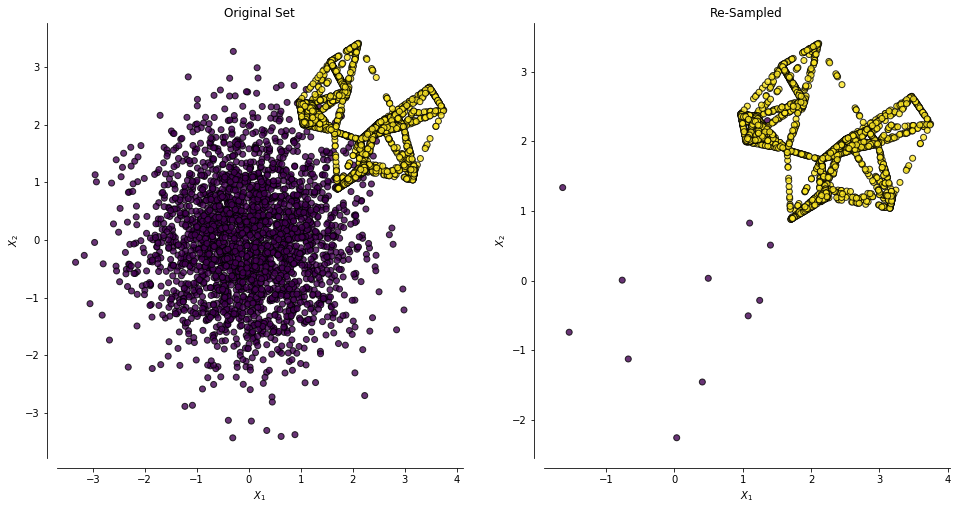

In [233]:
test_pd = pd.DataFrame({'X1': X_train_smote[::,0],'X2': X_train_smote[::,1], 'Class': y_train_smote})

test_pd.groupby('Class').count()

majority_percentage = 0.2

remove_n = int(sum(y_train_smote)/majority_percentage)
drop_indices = np.random.choice(test_pd[test_pd.Class == 0].index, remove_n, replace=True)
test_pd_subset = test_pd.drop(drop_indices)

X_smote_under = np.array(test_pd_subset.loc[:, test_pd_subset.columns != 'Class'])
y_smote_under = np.array(test_pd_subset.loc[:, test_pd_subset.columns == 'Class']).ravel()

plot_resample(X_train_smote, y_train_smote, X_smote_under, y_smote_under)

In [234]:
#Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
smote_under_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
smote_under_model.fit(X_smote_under, y_smote_under);

# Correct the intercept 
correct_intercept_logit(smote_under_model, y_train, y_smote_under)

# Make predictions on testing values
smote_pred_under = smote_under_model.predict(X_test)

# Get scores and display 
accuracy_smote_under = metrics.accuracy_score(y_test, smote_pred_under)

print('Overall accuracy score with SMOTE and Under-Sampling: ' + str(accuracy_smote_under) + "\n")
print(metrics.classification_report(y_test, smote_pred_under))

Overall accuracy score with SMOTE and Under-Sampling: 0.992

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2475
         1.0       0.59      0.68      0.63        25

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.79      0.84      0.81      2500
weighted avg       0.99      0.99      0.99      2500



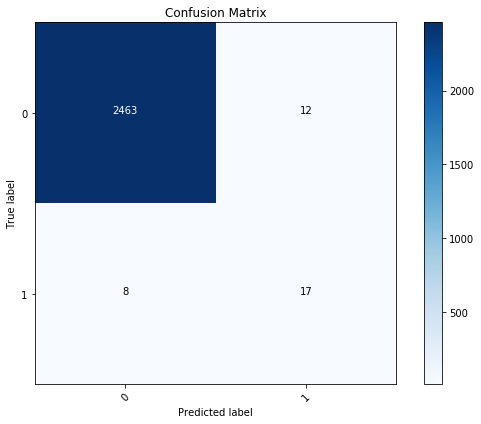

In [235]:
cnf_smote_under = metrics.confusion_matrix(y_test, smote_pred_under)

plot_confusion(cnf_smote_under)

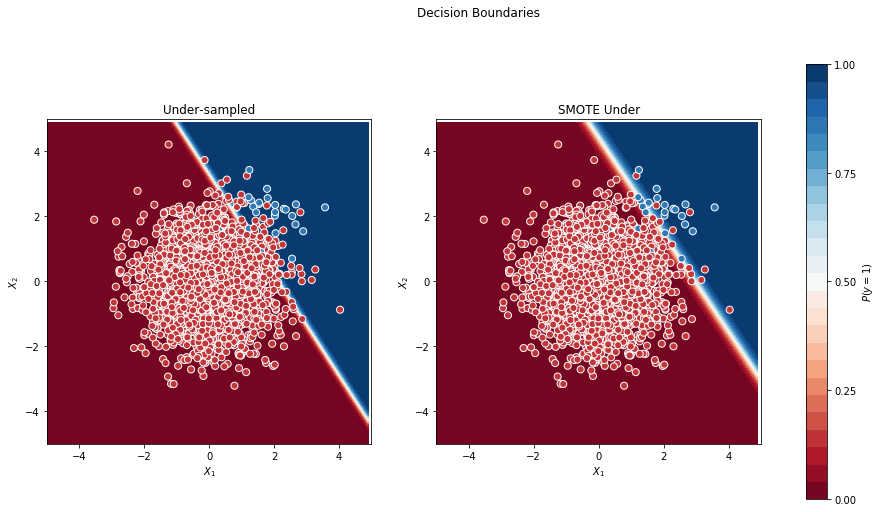

In [236]:
plot_decision_resample([undersampled_model, smote_under_model],X_test, y_test, titles= ['Under-sampled','SMOTE Under'])

#### Simulation

- Now that I've demonstrated the basic ideas behind all methods, time to make simulations in higher dimensions
- I'm primarily interested in what drives the performance of each sampling method and when / how which method stands out
- 

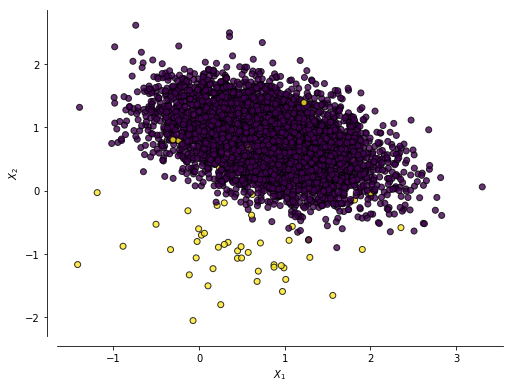

In [595]:
from sklearn.datasets import make_classification

base_rate = 0.01

# Make a new dataset
x, y = make_classification(n_samples = 5000,n_features = 2, n_informative =2, n_redundant = 0, n_repeated =0,
                          n_classes = 2, n_clusters_per_class = 1, weights =  [1-base_rate],
                          class_sep = 0.8)



In [557]:
def sample_fit_metrics(model, X, y, strategy):
    
    # Train-test-split
    
    
    

50.0

In [612]:
%%time
import warnings
warnings.filterwarnings("ignore")

rates = np.linspace(0.01, 0.2, 20)

n_simulations = 100

avg_undersampling_accuracy = []
avg_undersampling_precision =[]
avg_undersampling_recall = []
avg_baseline_accuracy = []
avg_baseline_precision= []
avg_baseline_recall = []

model =  LogisticRegression(C = 1,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Instantiate the undersample, making completly balanced sample
rus = RandomUnderSampler(sampling_strategy=1)
for base_rate in rates:
    print(base_rate)
    baseline_accuracy = []
    baseline_precision = []
    baseline_recall = []
    undersampling_accuracy = []
    undersampling_precision = []
    undersampling_recall = []
    
    for i in range(0,n_simulations):
    
        # Make a new dataset
        x, y = make_classification(n_samples = 1000,n_features = 50, n_informative =10, n_redundant = 0, n_repeated =0,
                          n_classes = 2, n_clusters_per_class = 1, weights =  [1-base_rate],
                          class_sep = 0.2)
    
        # Train test, split
        X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, stratify = y)
    
        # Run baseline
        model.fit(X_train,y_train)
    
        # Make prediction on testing set
        baseline_prediction = model.predict(X_test)
    
        # Store metrics
        baseline_accuracy.append(metrics.accuracy_score(y_test,baseline_prediction))
        baseline_precision.append(metrics.precision_score(y_test,baseline_prediction))
        baseline_recall.append(metrics.recall_score(y_test,baseline_prediction))
        
        # Undersampling 
        X_train_undersampled, y_train_undersampled = smote.fit_resample(X_train, y_train)
        
        # Re-fit model on undersampled data-set
        model.fit(X_train_undersampled,y_train_undersampled)
        
        # Correct the intercept
        correct_intercept_logit(model,y_train,y_train_undersampled)
        
        # Predict new
        undersampled_pred = model.predict(X_test)
        
        # Store accuracy
        undersampling_accuracy.append(metrics.accuracy_score(y_test,undersampled_pred))
        undersampling_precision.append(metrics.precision_score(y_test, undersampled_pred)) 
        undersampling_recall.append(metrics.recall_score(y_test, undersampled_pred))
        
    # Store averages over all simulations for certain base rate
    avg_undersampling_accuracy.append(np.mean(undersampling_accuracy))
    avg_undersampling_precision.append(np.mean(undersampling_precision))
    avg_undersampling_recall.append(np.mean(undersampling_recall))
    avg_baseline_accuracy.append(np.mean(baseline_accuracy))
    avg_baseline_precision.append(np.mean(baseline_precision))
    avg_baseline_recall.append(np.mean(baseline_recall))
    


0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
CPU times: user 2min 33s, sys: 4.83 s, total: 2min 38s
Wall time: 1min 19s


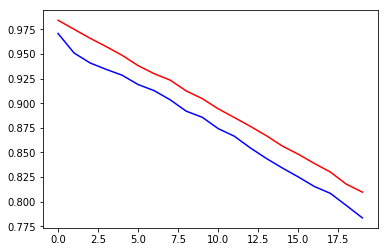

In [613]:
plt.plot(avg_undersampling_accuracy, color = 'blue')
plt.plot(avg_baseline_accuracy, color = 'red')

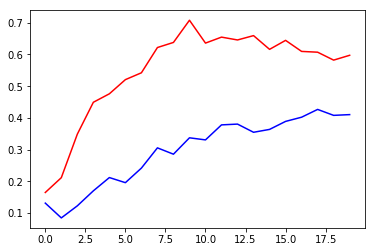

In [614]:
plt.plot(avg_undersampling_precision, color = 'blue')
plt.plot(avg_baseline_precision,color = "red")

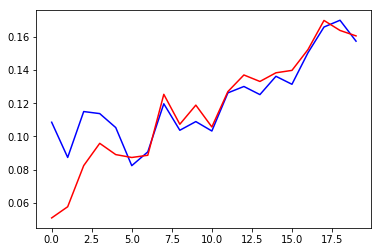

In [615]:
plt.plot(avg_undersampling_recall, color = 'blue')
plt.plot(avg_baseline_recall, color = 'red')

In [616]:
avg_undersampling_recall

[0.1085,
 0.08728571428571427,
 0.11494444444444446,
 0.11371212121212122,
 0.10528205128205126,
 0.08233088235294117,
 0.09062629613248807,
 0.11963523433088649,
 0.10366673254281951,
 0.10889800569800569,
 0.1032165663200146,
 0.1262043010752688,
 0.13005328495034377,
 0.12516173316173315,
 0.13619328336433598,
 0.13138408556843043,
 0.15039261384610222,
 0.16589213947990541,
 0.16997961858193786,
 0.15736881521839508]

In [617]:
avg_baseline_recall

[0.05083333333333333,
 0.05757142857142857,
 0.08236111111111111,
 0.0957878787878788,
 0.08900183150183148,
 0.08725735294117648,
 0.08858963585434174,
 0.1253232636928289,
 0.10728478260869563,
 0.11881253561253562,
 0.10565042875387701,
 0.12696639784946234,
 0.1369923446651388,
 0.13307807807807812,
 0.13830599627968046,
 0.13975831915295897,
 0.1522944058525454,
 0.16985630588960837,
 0.1638323476939342,
 0.16053929879644166]